# Libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor


# loading the dataset

In [41]:
file_path = 'AAPL_short_volume.csv'
data = pd.read_csv(file_path)

data = data.iloc[::-1].reset_index(drop=True)

print(data.head())
print(data.info())


  Date  Short Vol  Short Exempt Vol  Total Vol  % Shorted  Close
0  NaN        NaN               NaN        NaN        NaN    NaN
1  NaN        NaN               NaN        NaN        NaN    NaN
2  NaN        NaN               NaN        NaN        NaN    NaN
3  NaN        NaN               NaN        NaN        NaN    NaN
4  NaN        NaN               NaN        NaN        NaN    NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              251 non-null    object 
 1   Short Vol         251 non-null    float64
 2   Short Exempt Vol  251 non-null    float64
 3   Total Vol         251 non-null    float64
 4   % Shorted         251 non-null    float64
 5   Close             251 non-null    float64
dtypes: float64(5), object(1)
memory usage: 28.0+ KB
None


# Computing the technical indicators

In [42]:
def compute_technical_indicators(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    return data


data = compute_technical_indicators(data)
data = data.dropna().reset_index(drop=True)

print(data.head())


         Date   Short Vol  Short Exempt Vol   Total Vol  % Shorted  \
0  15/08/2022  13761083.0           64392.0  22826504.0      60.29   
1  16/08/2022  13968825.0           77788.0  22920291.0      60.95   
2  17/08/2022  16432273.0           77289.0  35438689.0      46.37   
3  18/08/2022  12308593.0          208845.0  27252240.0      45.17   
4  19/08/2022  13087281.0          126396.0  28402453.0      46.08   

        Close      SMA_10      SMA_20      EMA_10      EMA_20        RSI  \
0  172.401108  166.182341  160.438810  166.377973  162.153077  85.911806   
1  172.241852  167.500505  161.545718  167.444133  163.113913  82.486569   
2  173.754929  168.361609  162.626886  168.591550  164.127343  83.126575   
3  173.356735  169.214703  163.573329  169.457948  165.006333  77.545744   
4  170.738724  169.828891  164.451498  169.690816  165.552275  72.085587   

       MACD  MACD_Signal  
0  4.919731     3.815662  
1  5.104038     4.073338  
2  5.310974     4.320865  
3  5.380815   

# Features

In [43]:
if 'Close' not in data.columns:
    raise KeyError("The 'Close' column is missing from the dataset. Cannot calculate features.")

data['SMA_10'] = data['Close'].rolling(window=10, min_periods=1).mean()
data['SMA_20'] = data['Close'].rolling(window=20, min_periods=1).mean()

data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)

data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

print("Feature creation completed. Columns now include:")
print(data[['SMA_10', 'SMA_20', 'EMA_10', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal']].head())


Feature creation completed. Columns now include:
       SMA_10      SMA_20      EMA_10      EMA_20        RSI      MACD  \
0  172.401108  172.401108  172.401108  172.401108        NaN  0.000000   
1  172.321480  172.321480  172.372152  172.385941   0.000000 -0.012704   
2  172.799296  172.799296  172.623566  172.516320  90.477015  0.098188   
3  172.938656  172.938656  172.756870  172.596360  73.076921  0.152186   
4  172.498669  172.498669  172.389934  172.419442  32.271828 -0.016086   

   MACD_Signal  
0     0.000000  
1    -0.002541  
2     0.017605  
3     0.044521  
4     0.032400  


# Preprocessing

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

required_features = ['SMA_10', 'SMA_20', 'EMA_10', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal']

missing_features = [col for col in required_features if col not in data.columns]
if missing_features:
    raise KeyError(f"Missing required features: {missing_features}. Ensure feature creation is run first.")

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

numeric_imputer = SimpleImputer(strategy='mean')
data[numeric_cols] = numeric_imputer.fit_transform(data[numeric_cols])

if len(categorical_cols) > 0:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[required_features])

processed_data = pd.DataFrame(scaled_features, columns=required_features)
processed_data['Close'] = data['Close'].values 

X = processed_data[required_features]
y = processed_data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (185, 7), X_test shape: (47, 7)
y_train shape: (185,), y_test shape: (47,)


# Model initialization

In [45]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


# Training

In [46]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)

print("RandomForest Model Evaluation:")
print(f"R²: {r2_score(y_test, y_pred_rf):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE: {calculate_rmse(y_test, y_pred_rf):.2f}")

print("\nXGBoost Model Evaluation:")
print(f"R²: {r2_score(y_test, y_pred_xgb):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {calculate_rmse(y_test, y_pred_xgb):.2f}")

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)

model.fit(X_train, y_train)

print("Model trained successfully!")



RandomForest Model Evaluation:
R²: 0.98
MAE: 1.86
RMSE: 2.40

XGBoost Model Evaluation:
R²: 0.97
MAE: 2.25
RMSE: 2.87
Model trained successfully!


# Evaluation

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5  
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results = {
    'RMSE': rmse,
    'MAE': mae,
    'R²': r2
}

print("Final Evaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


Final Evaluation Results:
RMSE: 2.4035
MAE: 1.8640
R²: 0.9757


# Cross validation

In [48]:

cross_val_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')

print(f"Cross-validation RMSE scores: {-cross_val_scores}")
print(f"Mean RMSE: {-cross_val_scores.mean():.2f}")


Cross-validation RMSE scores: [ 30.13976019  24.91502542  27.47961578  28.65891421 151.94979415]
Mean RMSE: 52.63


# Parameter Tuning

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

best_rf_model = grid_search.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test)

mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
print(f"RMSE for tuned Random Forest: {rmse_best_rf:.2f}")

print(data.isnull().sum())
print(data.describe())



Best parameters from GridSearchCV: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
RMSE for tuned Random Forest: 2.39
Date                0
Short Vol           0
Short Exempt Vol    0
Total Vol           0
% Shorted           0
Close               0
SMA_10              0
SMA_20              0
EMA_10              0
EMA_20              0
RSI                 0
MACD                0
MACD_Signal         0
EMA_12              0
EMA_26              0
dtype: int64
          Short Vol  Short Exempt Vol     Total Vol   % Shorted       Close  \
count  2.320000e+02        232.000000  2.320000e+02  232.000000  232.000000   
mean   1.374236e+07     110720.836207  2.916935e+07   47.196121  156.760675   
std    5.465371e+06      54019.678332  1.066028e+07    7.587821   16.919785   
min    6.018671e+06      33430.000000  1.396917e+07   32.730000  124.656982   
25%    9.519389e+06      75376.500000  2.089640e+07   41.037500  144.668018   
50%    1.262729e+07     101977.000000  2.724297e+0

# Model saving

In [50]:
import joblib

joblib.dump(rf, 'stock_prediction_model.pkl')



['stock_prediction_model.pkl']

# Application phase

In [51]:
y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)

if r2_score(y_test, y_pred_rf) > r2_score(y_test, y_pred_xgb):
    best_model = model_rf
else:
    best_model = model_xgb

y_pred_best = best_model.predict(X_test)

print(f"Predictions with the best model: {y_pred_best}")

print(f"R² of the best model: {r2_score(y_test, y_pred_best):.2f}")
print(f"MAE of the best model: {mean_absolute_error(y_test, y_pred_best):.2f}")
print(f"RMSE of the best model: {calculate_rmse(y_test, y_pred_best):.2f}")


Predictions with the best model: [190.21749985 147.55413375 167.25118543 165.89433638 156.68405577
 179.46150235 152.4567099  172.87166139 159.15166244 150.49535141
 186.72169817 154.82364317 128.93523352 168.18280774 164.87862593
 146.61737715 150.63463989 150.46459733 189.97589813 172.67743975
 135.85639382 162.96418671 180.73660445 166.2117877  150.16058152
 153.09869552 152.59758132 129.40136465 133.31556541 143.66500212
 176.79163011 140.98947173 147.02292405 141.30969328 156.40444289
 151.6252423  163.85820102 149.12096512 141.26438934 151.22424942
 132.17135194 173.39294114 149.17740097 148.28543167 142.2428642
 141.20259487 156.95300903]
R² of the best model: 0.98
MAE of the best model: 1.86
RMSE of the best model: 2.40


# visualization

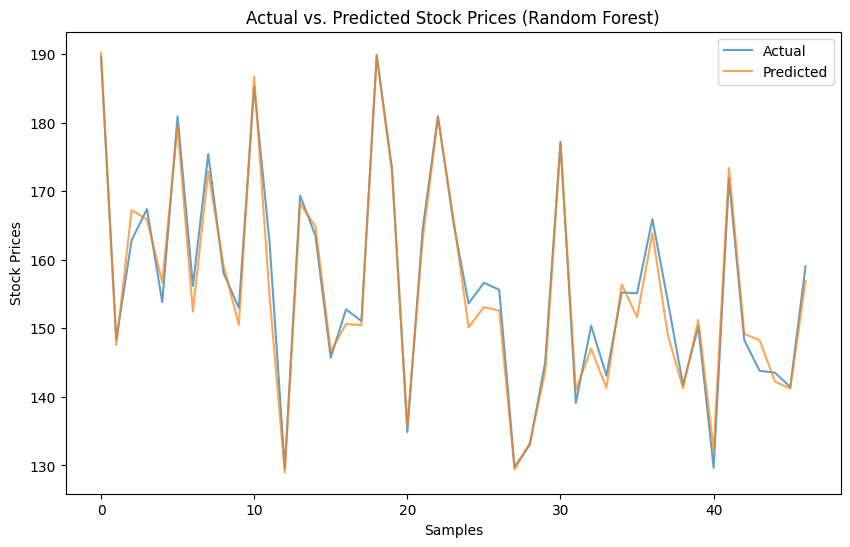

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred_rf, label="Predicted", alpha=0.7)
plt.title("Actual vs. Predicted Stock Prices (Random Forest)")
plt.xlabel("Samples")
plt.ylabel("Stock Prices")
plt.legend()
plt.show()


In [53]:
print("Model trained:", 'model' in locals())
print("X_train available:", 'X_train' in locals())
print("Results available:", 'results' in locals())

Model trained: True
X_train available: True
Results available: True


# Feature importance

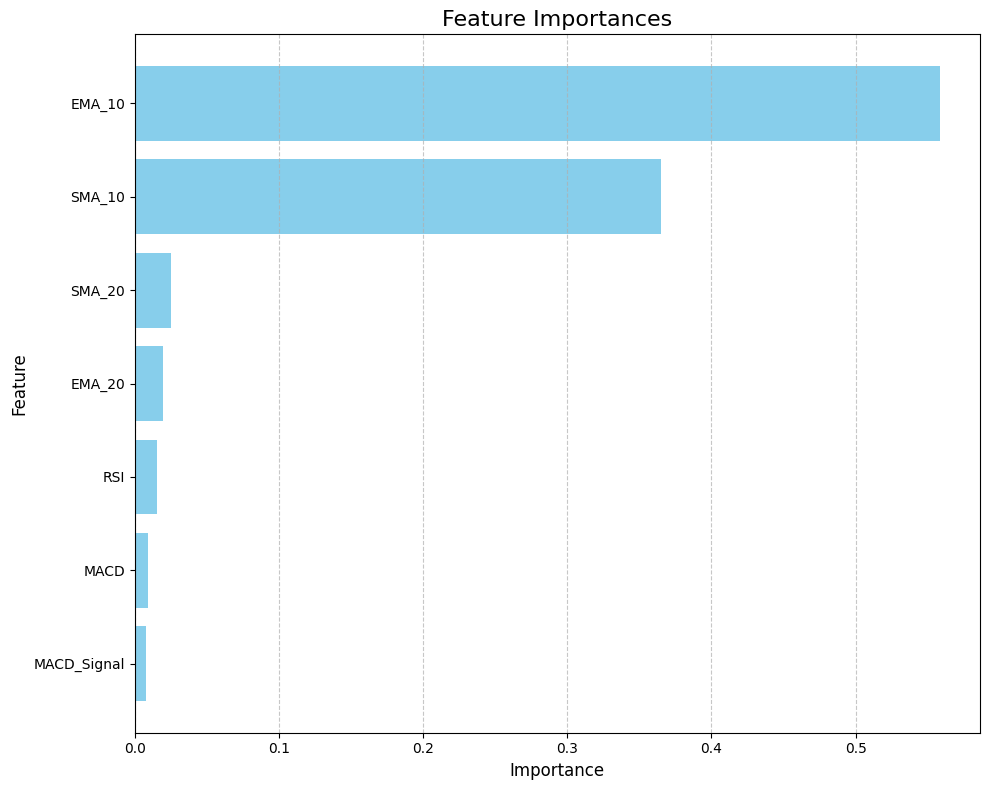

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

importances = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importances', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


# Accuracy of the model

In [55]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

results = {
    "RandomForest": {"Model": rf},
    "XGBoost": {"Model": xgb}
}

for model_name, model_info in results.items():
    model = model_info['Model']
    r2_score = model.score(X_test, y_test) 
    print(f"{model_name} - R²: {r2_score:.2f}")


RandomForest - R²: 0.98
XGBoost - R²: 0.96
